In [7]:
import sys,os
import numpy as np
import pandas as pd
import time, datetime
import random
import argparse
import math

import matplotlib.pyplot as plt


%matplotlib inline

### Modifications
 * pre-clustering of binary matrix reduces initial number of gene clusters
 * create UP- and DOWN- regulated matrice when run GMM binarization

In [8]:
min_n_samples = -1
direction = "DOWN"
out_dir = os.getcwd()+"/tmp_results/"
basename = "results"
seed = 42
alpha = 1.0
beta_K = 1.0
snr_pval = 0.05

# convergence
max_n_steps= 200
n_steps_averaged = 20
n_steps_for_convergence = 5
min_pletau_steps = 20
n_points_fit=10

verbose = True
plot_all = True

random.seed(seed)


#exprs_file = "../../Expression/Harmonized_final/TCGA_RNAseq.RSEM.log2.z.13K_common.tsv"
#exprs_file = root+"/Expression/Harmonized_final/TCGA_micro_nolog2.z.13K_common.tsv"
#exprs_file = "../datasets/METABRIC_1904.nolog2_exprs_z.tsv"
#exprs_file = "../datasets/METABRIC_299TNBC.nolog2_exprs_z.tsv"
#exprs_file = "../datasets/TCGA-BRCA_139TNBC.Xena.log2RSEM_norm_z.24K_genes.tsv"
#exprs_file = "../datasets/TCGA-BRCA_945.Xena.log2RSEM_norm_z.24K_genes.tsv"
exprs_file = "../../../SFU/Breast_cancer/Expression/Harmonized_final/TCGA_micro_nolog2.z.13K_common.tsv"

In [9]:
start_time = time.time()

if basename:
    basename = basename
else: 
    [date_h,mins] = str(datetime.datetime.today()).split(":")[:2]
    [date, hs] = date_h.split()
    basename = "results_"+hs+":"+mins+"_"+date 
    
suffix  = ".alpha="+str(alpha)+",beta_K="+str(beta_K)+",direction="+direction
if verbose:
    print("Will save output files to:",out_dir + basename + suffix, file = sys.stdout)
    
# read inputs
exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

# define minimal number of patients in a module
if min_n_samples == -1:
    min_n_samples = int(max(5,0.05*exprs.shape[1])) # set to max(10, 5% of the cohort) 
if verbose:
    print("Mininal number of samples in a module:",min_n_samples ,file=sys.stdout)

Will save output files to: /home/olya/TUM/DESMOND/DESMOND2/tmp_results/METABRIC_24K.alpha=1.0,beta_K=1.0,direction=DOWN
Mininal number of samples in a module: 26


# 0) Find the trend between SNR and bicluster size

1) generate random splits for all bicluster sizes [min_n_samples, N/2]

2) find SNR_thr(size) for a p-value cutoff, e.g. p_val =0.05

get_snr_thr is a function of bicluser size 


In [10]:
from method2 import rand_norm_splits, get_trend

total samples: 529, min_n_samples: 26, n_permutations: 189


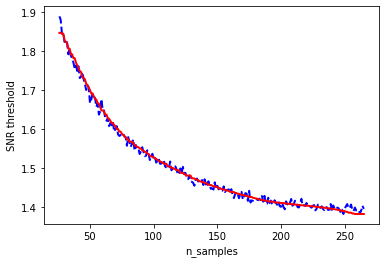

In [11]:
sizes,thresholds = rand_norm_splits(exprs.shape[1], snr_pval = snr_pval,seed=seed)
get_min_snr = get_trend(sizes,thresholds, plot = plot_all)

# 1) Assign patients to edges
 * GMM
 * filtering by sample nubmer and SNR

		genes processed: 0
Gene SIDT1: SNR=2.03, pos=0, neg=92


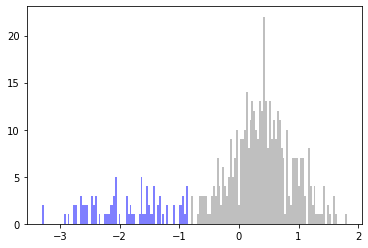

Gene CLIC6: SNR=-2.01, pos=186, neg=0


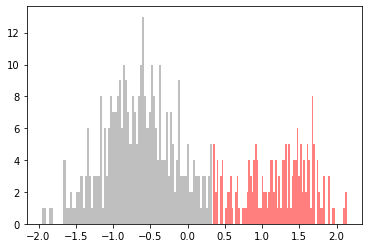

		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
Gene GRB7: SNR=2.56, pos=53, neg=0


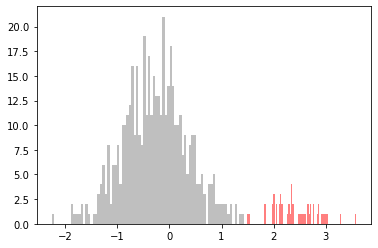

		genes processed: 4000
		genes processed: 5000
Gene ESR1: SNR=2.21, pos=0, neg=134


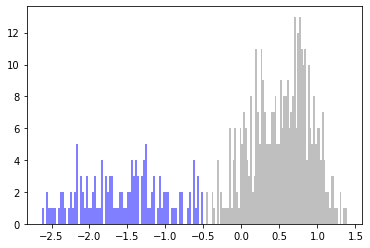

		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene ERBB2: SNR=2.19, pos=57, neg=0


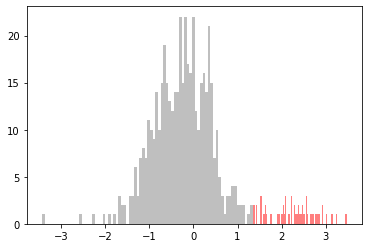

Gene GATA3: SNR=1.73, pos=0, neg=125


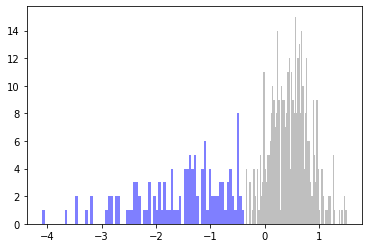

		genes processed: 9000
Gene FOXA1: SNR=2.57, pos=0, neg=94


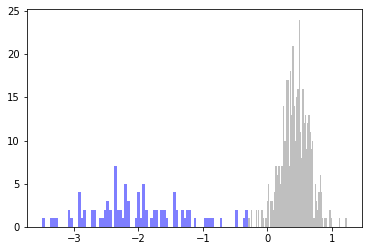

		genes processed: 10000
		genes processed: 11000
Gene BMPR1B: SNR=-2.16, pos=241, neg=288


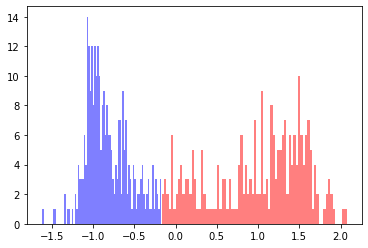

		genes processed: 12000
		genes processed: 13000
Total runtime 314.45 s for  13361 genes
	up-regulated genes: 1563
	down-regulated genes: 1012
	inexplicit genes: 378


In [12]:
from method2 import GM_binarization
sele_genes = ["SIDT1","CLIC6","BMPR1B", "FOXA1","GATA3","ESR1","ERBB2","GRB7"]
binarized_expressions = GM_binarization(exprs,get_min_snr,min_n_samples,verbose = True, 
                                        plot=True, plot_SNR_thr= 3.0, show_fits = sele_genes,seed = seed)


# Step 2. Sample module memberships

In [13]:
from method2 import set_initial_conditions, sampling, get_consensus_modules

In [14]:
direction = "UP"
exprs_bin = binarized_expressions[direction]
print(exprs_bin.shape)
exprs_bin.columns

(529, 1563)


Index(['ASS1', 'ZNF707', 'CEACAM5', 'NUP93', 'SP5', 'GTSE1', 'UGCG', 'ITGA7',
       'FBXL13', 'SDK1',
       ...
       'RGS13', 'LANCL3', 'IGFL2', 'ELF5', 'CAND2', 'LDHB', 'LDHC', 'SLC7A10',
       'FOLR1', 'GNGT1'],
      dtype='object', name='Hugo_Symbol', length=1563)

In [15]:
# simplifying probability calculations
N = exprs.shape[1]
max_log_float = np.log(np.finfo(np.float64).max)
n_exp_orders = 7 # ~1000 times 
p0 = N*np.log(0.5)+np.log(beta_K)
match_score = np.log((alpha*0.5+1)/(alpha))
mismatch_score = np.log((alpha*0.5+0)/alpha)
bK_1 = math.log(1+beta_K)
genes = exprs_bin.columns.values

In [16]:
print("Direction:",direction)
moduleSizes, gene2Samples, nOnesPerSampleInModules, gene2Module, moduleOneFreqs, LP  = set_initial_conditions(exprs_bin, alpha,beta_K,verbose = True)
K = len(moduleSizes)
N = gene2Samples.shape[1]
print("\t\tLP memory, {:.2f} M".format(LP.nbytes/(1024*1024)),file = sys.stdout)


Direction: UP
		KxN=1563x529
		p0= -366.67485851621103
	 1000 genes processed in  7.3 s
time:	Initial state created in 8.1 s.
		LP memory, 18.64 M


In [17]:
t0 = time.time()
gene2Module_history,n_final_steps,n_skipping_genes,P_diffs = sampling(LP,gene2Module, gene2Samples, nOnesPerSampleInModules,moduleSizes,moduleOneFreqs, p0, match_score,mismatch_score, bK_1, alpha, beta_K, 
                                                                          max_n_steps=max_n_steps, n_steps_averaged = n_steps_averaged, n_points_fit = n_points_fit, tol = 0.1, 
                                                                          n_steps_for_convergence = n_steps_for_convergence, verbose=True)

print("time:\tSampling (%s steps) fininshed in %s s." %(len(gene2Module_history),round(time.time()-t0,2)), file = sys.stdout)


step 1
1000 		genes processed in 36.7 s runtime...
	step  1 54.1 s
step 2
1000 		genes processed in 9.3 s runtime...
	step  2 16.6 s
step 3
1000 		genes processed in 6.7 s runtime...
	step  3 10.6 s
step 4
1000 		genes processed in 4.4 s runtime...
	step  4 8.4 s
step 5
1000 		genes processed in 3.0 s runtime...
	step  5 5.4 s
step 6
1000 		genes processed in 3.0 s runtime...
	step  6 5.8 s
step 7
1000 		genes processed in 3.7 s runtime...
	step  7 7.3 s
step 8
1000 		genes processed in 3.6 s runtime...
	step  8 5.8 s
step 9
1000 		genes processed in 4.0 s runtime...
	step  9 7.0 s
step 10
1000 		genes processed in 3.3 s runtime...
	step  10 6.2 s
step 11
1000 		genes processed in 3.4 s runtime...
	step  11 6.3 s
step 12
1000 		genes processed in 3.3 s runtime...
	step  12 5.6 s
step 13
1000 		genes processed in 2.8 s runtime...
	step  13 5.2 s
step 14
1000 		genes processed in 3.7 s runtime...
	step  14 7.9 s
step 15
1000 		genes processed in 3.4 s runtime...
	step  15 6.1 s
step 16
1

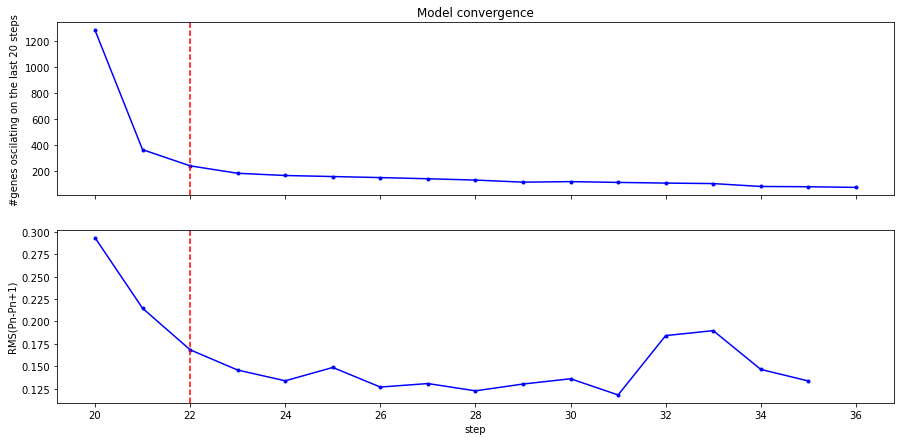

In [18]:
if plot_all:
    from method2 import plot_convergence
    plot_outfile = out_dir + basename +suffix+",ns_max=" + str(max_n_steps)+ ",ns_avg=" + str(n_steps_averaged) + ",ns_c="+str(n_steps_for_convergence) + ".convergence.svg"
    plot_convergence(n_skipping_genes, P_diffs,len(gene2Module_history)-n_final_steps,
                     n_steps_averaged, outfile=plot_outfile)


In [19]:
consensus, nOnesPerSampleInModules, moduleSizes, moduleOneFreqs = get_consensus_modules(gene2Module_history[-n_final_steps:], LP,  gene2Samples, gene2Module,
                      nOnesPerSampleInModules,moduleSizes, moduleOneFreqs, p0, match_score,mismatch_score,
                      bK_1,alpha,beta_K,N, K)

print("\tEmpty modules:", len([x for x in moduleSizes if x == 0]),
  "\n\tNon-empty modules:",len([x for x in moduleSizes if x > 0]),file = sys.stdout)

print("size(genes)\tn_modules")
for m in set(moduleSizes):
    print(m, "\t\t",len([x for x in moduleSizes if x==m]))

	edge: 914 counts: [2 6 6 1] 
	labels: 719,934,1290,1392
	edge: 1496 counts: [4 4 7] 
	labels: 882,1190,1496
17 genes changed their module membership after taking consensus.
	Empty modules: 952 
	Non-empty modules: 611
size(genes)	n_modules
0 		 952
1 		 123
2 		 456
3 		 10
4 		 6
5 		 3
7 		 1
8 		 2
12 		 1
13 		 1
16 		 1
84 		 1
21 		 1
20 		 1
154 		 1
27 		 2
62 		 1


# 3) Define biclusters

In [20]:
exprs_np = exprs.loc[genes,:]
ints2g_names = exprs_np.index.values
ints2s_names = exprs_np.columns.values
exprs_np = exprs_np.values
exprs_sums = exprs_np.sum(axis=1)
exprs_sq_sums = np.square(exprs_np).sum(axis=1)
N = exprs.shape[1]
exprs_data = N, exprs_sums, exprs_sq_sums

In [21]:
from method2 import genesets2biclusters,  write_bic_table

# Identify optimal patient sets for each module: split patients into two sets in a subspace of each module
# Filter out bad biclusters with too few genes or samples, or with low SNR
filtered_bics = genesets2biclusters(exprs_np, exprs_data,moduleSizes,consensus,
                        min_SNR = 0.5,direction=direction,min_n_samples=min_n_samples,
                        verbose = verbose)
i =0
print()
for bic in filtered_bics:
    bic["id"] = i
    i+=1
    bic["genes"] = set(sorted([ints2g_names[x] for x in bic["genes"]]) )
    bic["samples"] = set(sorted([ints2s_names[x] for x in bic["samples"]]))
    if len(bic["genes"])>2:
        print("\t".join(map(str,[str(bic["n_genes"])+"x"+str(bic["n_samples"]),
                                 round(bic["avgSNR"],3)," ".join(bic["genes"])])),file = sys.stdout)

time:	Identified optimal sample sets for 1563 modules in 69.02 s.
	Empty modules: 123
	Modules with just 1 edge: 123
	Modules with not enough or too many samples: 0
	Modules not passed avg. |SNR| threshold: 2
Passed modules with >= 2 genes and >= 26 samples: 486

8x232	0.883	APRT KATNB1 NUDT21 NIP7 AP1G1 DHODH SF3B3 DDX28
4x131	1.401	S100A7 S100A7A S100A9 S100A8
5x188	1.059	SCRIB COMMD5 ADCK5 HSF1 ZNF707
5x213	1.188	HIST1H2AM HIST1H1C HIST1H1E HIST1H3H HIST1H4H
3x193	1.013	TSLP SPRY2 PAK7
16x239	1.013	MELK AURKB CENPI CDCA8 CENPO KIF18A MCM4 CHEK1 UBE2C CENPN BLM PDSS1 GPSM2 TTK RFC4 ATAD2
27x151	1.035	GRIN3A P2RX5 CD79B PDCD1 FCRL5 PNOC PTPN7 CD7 IL2RG LY9 XCL1 PRF1 SLA2 IFNG PKHD1L1 CD79A CD200R1 IRF4 BTLA KRT81 PTPRCAP KLHL6 CD19 CD72 AIM2 CTSW IGLL1
12x234	1.172	EOMES SIRPG GPR18 SAMD3 FASLG NKG7 GPR171 PYHIN1 SLAMF1 CCR2 IL18RAP CXCR6
3x182	1.181	APOBEC3A LAG3 ICOS
21x109	0.977	GYPC LCN6 PDE2A FXYD1 CA4 CDO1 CPA1 MAP1LC3C HSPB6 LYVE1 KCNIP2 ITIH5 GLYAT ITGA7 TSPAN7 CHRDL1 NPR1 PEN

In [22]:
result_file_name = out_dir+basename+suffix
write_bic_table(filtered_bics,
                result_file_name+".biclusters.tsv")


print("Total runtime:",round(time.time()-start_time,2),file = sys.stdout)

Total runtime: 670.01


In [23]:
print(result_file_name)

/home/olya/TUM/DESMOND/DESMOND2/tmp_results/METABRIC_24K.alpha=1.0,beta_K=1.0,direction=DOWN


# All steps in one function

In [1]:
import sys,os
import numpy as np
import pandas as pd
import time, datetime
import random
import argparse
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from method2 import rand_norm_splits, get_trend, GM_binarization
from method2 import set_initial_conditions, sampling, get_consensus_modules
from method2 import genesets2biclusters,  write_bic_table

In [3]:
def run_DESMOND(exprs_file, out_dir = "./",basename = False,
                min_n_samples = -1,
                alpha=1.0 ,beta_K=1.0, snr_pval = 0.05,
                max_n_steps= 200, n_steps_averaged = 20, n_steps_for_convergence = 5, n_points_fit=10,
                plot_all=True, verbose = True, seed= 42):
    
    biclusters = {} # UP and DOWN
    start_time = time.time()

    if basename:
        basename = basename
    else: 
        [date_h,mins] = str(datetime.datetime.today()).split(":")[:2]
        [date, hs] = date_h.split()
        basename = "results_"+hs+":"+mins+"_"+date 

    suffix  = ".alpha="+str(alpha)+",beta_K="+str(beta_K)
    if verbose:
        print("Will save output files to: %s*."% (out_dir + basename + suffix), file = sys.stdout)

    # read inputs
    exprs = pd.read_csv(exprs_file, sep="\t",index_col=0)

    # define minimal number of patients in a module
    if min_n_samples == -1:
        min_n_samples = int(max(5,0.05*exprs.shape[1])) # set to max(10, 5% of the cohort) 
    if verbose:
        print("Mininal number of samples in a module:",min_n_samples ,file=sys.stdout)
    
    #### Computing min_SNR(size) ###
    sizes,thresholds = rand_norm_splits(exprs.shape[1], snr_pval = snr_pval,seed=seed)
    get_min_snr = get_trend(sizes,thresholds, plot = plot_all)
    
    ####1. Binarization ####
    sele_genes = ["SIDT1","CLIC6","BMPR1B", "FOXA1","GATA3","ESR1","ERBB2","GRB7"]
    binarized_expressions = GM_binarization(exprs,get_min_snr,min_n_samples,verbose = True, 
                                        plot=True, plot_SNR_thr= 3.0, show_fits = sele_genes,seed = seed)    
    ### 2. Edge clustering ###
    
    # simplifying probability calculations
    N = exprs.shape[1]
    max_log_float = np.log(np.finfo(np.float64).max)
    n_exp_orders = 7 # ~1000 times 
    p0 = N*np.log(0.5)+np.log(beta_K)
    match_score = np.log((alpha*0.5+1)/(alpha))
    mismatch_score = np.log((alpha*0.5+0)/alpha)
    bK_1 = math.log(1+beta_K)
    
    i = 0
    for direction in ["UP","DOWN"]:
        t1 = time.time()
        exprs_bin = binarized_expressions[direction]
        genes = exprs_bin.columns.values
        # setting initial model state
        print("Searching for %s-regulated biclusters ..."%direction)
        moduleSizes, gene2Samples, nOnesPerSampleInModules, gene2Module, moduleOneFreqs, LP  = set_initial_conditions(exprs_bin, alpha,beta_K,verbose = verbose)
        K = len(moduleSizes)
        N = gene2Samples.shape[1]
        print("\t\tLP matrix memory usage: {:.2f}M".format(LP.nbytes/(1024*1024)),file = sys.stdout)

        # sampling
        t0 = time.time()
        gene2Module_history,n_final_steps,n_skipping_genes,P_diffs = sampling(LP,gene2Module, gene2Samples, nOnesPerSampleInModules,
                                                                              moduleSizes,moduleOneFreqs, p0, match_score,mismatch_score,
                                                                              bK_1, alpha, beta_K, max_n_steps=max_n_steps, tol = 0.1,
                                                                              n_steps_averaged = n_steps_averaged, n_points_fit = n_points_fit, 
                                                                              n_steps_for_convergence = n_steps_for_convergence, verbose=True)

        print("time:\tSampling (%s steps) fininshed in %s s." %(len(gene2Module_history),round(time.time()-t0,2)), file = sys.stdout)
        if plot_all:
            from method2 import plot_convergence
            plot_outfile = out_dir + basename +suffix+",ns_max=" + str(max_n_steps)+ ",ns_avg=" + str(n_steps_averaged) + ",ns_c="+str(n_steps_for_convergence) + ".convergence.svg"
            plot_convergence(n_skipping_genes, P_diffs,len(gene2Module_history)-n_final_steps,
                             n_steps_averaged, outfile=plot_outfile)

        # take the last (n_points_fit+n_steps_for_convergence) steps modules:
        # and get consensus edge-to-module membership
        consensus, nOnesPerSampleInModules, moduleSizes, moduleOneFreqs = get_consensus_modules(gene2Module_history[-n_final_steps:], 
                                                                                                LP, gene2Samples, gene2Module,
                                                                                                nOnesPerSampleInModules,moduleSizes, 
                                                                                                moduleOneFreqs, p0, 
                                                                                                match_score,mismatch_score,
                                                                                                bK_1,alpha,beta_K,N,K)

        print("\tEmpty modules:", len([x for x in moduleSizes if x == 0]),
              "\n\tNon-empty modules:",len([x for x in moduleSizes if x > 0]),file = sys.stdout)
        #### 3. Define biclusters and merge modules  ####
        exprs_np = exprs.loc[genes,:]
        ints2g_names = exprs_np.index.values
        ints2s_names = exprs_np.columns.values
        exprs_np = exprs_np.values
        exprs_sums = exprs_np.sum(axis=1)
        exprs_sq_sums = np.square(exprs_np).sum(axis=1)
        N = exprs.shape[1]
        exprs_data = N, exprs_sums, exprs_sq_sums
        # Identify optimal patient sets for each module: split patients into two sets in a subspace of each module
        # Filter out bad biclusters with too few genes or samples, or with low SNR
        filtered_bics = genesets2biclusters(exprs_np, exprs_data,moduleSizes,consensus,
                                min_SNR = 0.5,direction=direction,min_n_samples=min_n_samples,
                                verbose = verbose)
        # print info on found biclusters
        if verbose:
            for bic in filtered_bics:
                bic["id"] = i
                i+=1
                bic["genes"] = sorted([ints2g_names[x] for x in bic["genes"]])
                bic["samples"] = sorted([ints2s_names[x] for x in bic["samples"]])
                if len(bic["genes"])>2:
                    print("\t".join(map(str,[str(bic["n_genes"])+"x"+str(bic["n_samples"]),
                                             round(bic["avgSNR"],3)," ".join(bic["genes"])])),file = sys.stdout)
                        
        # save results 
        result_file_name = out_dir+basename+suffix+",direction="+direction
        write_bic_table(filtered_bics,result_file_name+".biclusters.tsv")
        if verbose:
            print("Runtime for %s-regulated biclusters: %s"%(direction, round(time.time()-t1,2)),file = sys.stdout)
        biclusters[direction] = filtered_bics
    
    biclusters = biclusters["UP"] + biclusters["DOWN"]
    result_file_name = out_dir+basename+suffix
    write_bic_table(biclusters,result_file_name+".biclusters.tsv")
    if verbose:
        print("Total runtime:",round(time.time()-start_time,2),file = sys.stdout)
        
    return biclusters


max_n_steps= 200
n_steps_averaged = 20
n_steps_for_convergence = 5
min_pletau_steps = 20
n_points_fit=10
seed = 42

#snr_pval = 0.05
snr_pval = 0.01

out_dir = "tmp_results/"

Will save output files to: tmp_results/METABRIC_13K_pv0.005.alpha=1.0,beta_K=1.0*.
Mininal number of samples in a module: 95
total samples: 1904, min_n_samples: 95, n_permutations: 1000


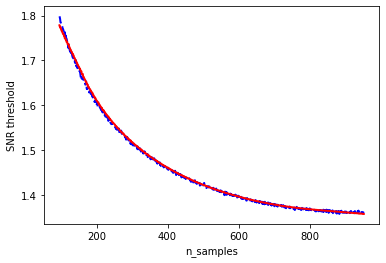

		genes processed: 0
Gene SIDT1: SNR=1.37, pos=0, neg=0


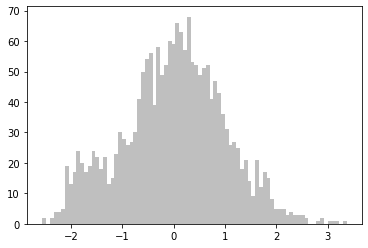

Gene CLIC6: SNR=-1.95, pos=762, neg=0


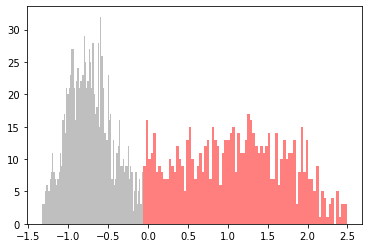

		genes processed: 1000
		genes processed: 2000
Gene HLA-A: SNR=3.75, pos=0, neg=464


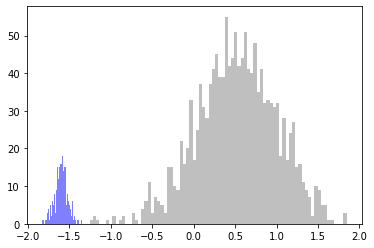

		genes processed: 3000
Gene GRB7: SNR=-2.14, pos=254, neg=0


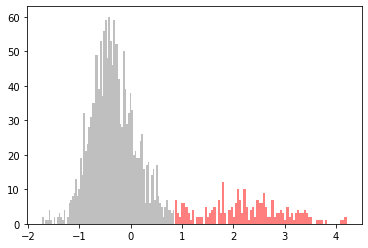

		genes processed: 4000
		genes processed: 5000
Gene ESR1: SNR=2.64, pos=0, neg=443


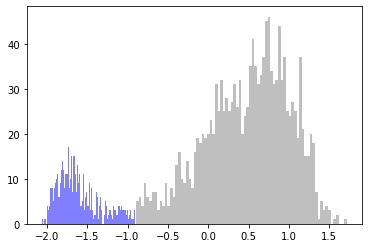

		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
Gene ERBB2: SNR=2.48, pos=217, neg=0


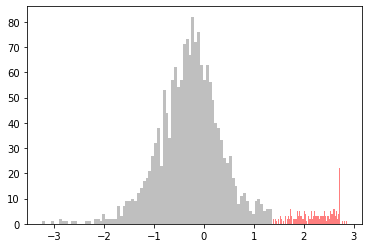

Gene GSTT1: SNR=-3.42, pos=0, neg=355


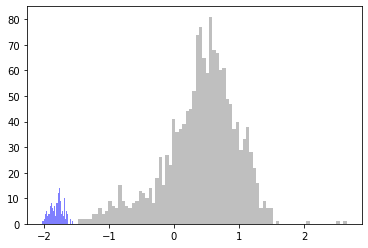

Gene GATA3: SNR=1.9, pos=0, neg=438


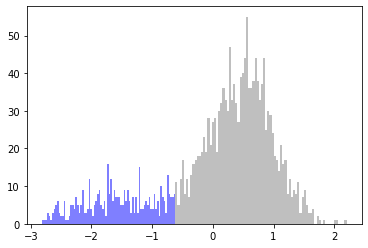

		genes processed: 9000
Gene FOXA1: SNR=2.83, pos=0, neg=254


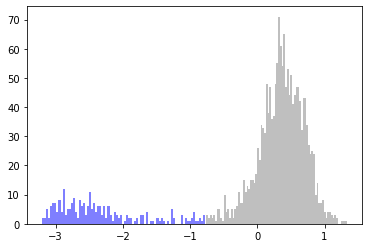

		genes processed: 10000
		genes processed: 11000
Gene BMPR1B: SNR=2.07, pos=887, neg=1017


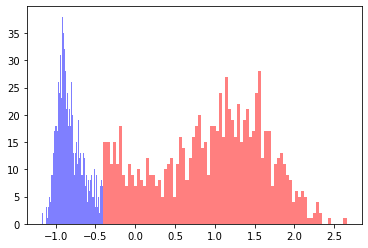

		genes processed: 12000


In [ ]:
exprs_file = "../../../SFU/Breast_cancer/Expression/Harmonized_final/METABRIC_micro_nolog2.z.13K_common.tsv"
basename= "METABRIC_13K_pv0.005"
bics3 = run_DESMOND(exprs_file, out_dir = out_dir,basename = basename,
                min_n_samples = -1, plot_all=True, verbose = True, seed= seed, snr_pval=0.005)